# TS2Vec Training
Purpose: perform self-supervised learning on unlabeled test data to train TS2Vec encoder

In [1]:
# repo for ts2vec
!git clone https://github.com/zhihanyue/ts2vec.git
%cd ts2vec

# wandb for tracking model training
!pip install wandb

Cloning into 'ts2vec'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 133 (delta 23), reused 21 (delta 21), pack-reused 94 (from 1)
Receiving objects: 100% (133/133), 37.01 KiB | 18.50 MiB/s, done.
Resolving deltas: 100% (67/67), done.
/content/ts2vec


In [2]:
# ensure  gpu is being used for training
import torch

print(f"GPU: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")

GPU: True
Device: NVIDIA L4


In [16]:
from google.colab import files
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

# train_data = np.load('/content/drive/MyDrive/CS230/test_data_ts2vec_train_normalized.npy')
train_data = np.load('/content/drive/MyDrive/CS230/avocado/gp_asinh/test_data_batch11_avocado.npy')
# val_data = np.load('/content/drive/MyDrive/CS230/avocado/gp_asinh/test_data_batch11_avocado.npy')

print(f"Train shape: {train_data.shape}")
# print(f"Val shape: {val_data.shape}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Train shape: (206565, 200, 6)


In [17]:
import sys
import os
import time
import wandb
from ts2vec import TS2Vec
from utils import init_dl_program

# login to wandb, need token
wandb.login()

True

In [18]:
# sometimes colab GPU memory gets stuck, so can't load in new data/model
# wipe out cache to free up gpu memory
# torch.cuda.empty_cache()

# model config
batch_size = 512 # ts2vec uses smaller batch size, but typically SSL contrastive models benefit from larger batch size as shown in papers like SimCLR, also over 512 batch size is not really feasible in colab settings, you need over 20GB of GPU RAM
lr = 0.001 # original ts2vec used 1e-3 as default
repr_dims = 320 # output embedding vector size, original ts2vec used 320 as default(tested with larger repr dims but can overfit and takes longer to train)
epochs = 20 # full test set takes about 4-5 hours for 5 epochs
device = init_dl_program(0, seed=42)
print(f"Device: {device}")

Device: cuda:0


In [19]:
# loss didn't plot as desired, so can comment out
# # log for wandb
# wandb.init(
#     project="ts2vec-plasticc",
#     config={
#         "batch_size": batch_size,
#         "lr": lr,
#         "repr_dims": repr_dims,
#         "epochs": epochs,
#         "hidden_dims": 128,
#         "depth": 10
#     }
# )

In [20]:
# initialize ts2vec
model = TS2Vec(
    input_dims=train_data.shape[-1],
    output_dims=repr_dims,
    hidden_dims=128,
    depth=10,
    device=device,
    lr=lr,
    batch_size=batch_size
)

In [21]:
print("Training...")
t = time.time()
print(f"Train shape: {train_data.shape}")

# create output dir
os.makedirs('output', exist_ok=True)

# original plan: for loop over desired # of epochs, but need to modify ts2vec code. ts2vec provides fit function
print(f"\nStarting training for {epochs} epochs.")
loss_log = model.fit(
    train_data,
    n_epochs=epochs,
    verbose=True
)

print(f"\nTime: {(time.time() - t)/60:.2f} min")
print(f"Total epochs trained: {len(loss_log)}")
print(f"Final train loss: {loss_log[-1]:.6f}")

# save model and logs as pkl so we don't lose trained info
model.save('output/model_final.pkl')
np.save('output/loss_log.npy', np.array(loss_log))
print("\nSaved model to output/model_final.pkl")

# # log epochs to wandb --> again, logging didnt work properly, but its ok since we are saving loss
# for epoch, train_loss in enumerate(loss_log):
#     global_step = (epoch + 1) * steps_per_epoch
#     wandb.log({
#         "step": global_step,
#         "epoch": epoch,
#         "train_loss": train_loss
#     })

# wandb.finish()

Training...
Train shape: (206565, 200, 6)
Steps per epoch: 403
Total epochs: 20

Starting training for 20 epochs...
Epoch #0: loss=2.177861124055261
Epoch #1: loss=1.3973043455971086
Epoch #2: loss=1.293991670567108
Epoch #3: loss=1.2349763561419163
Epoch #4: loss=1.167956257428484
Epoch #5: loss=1.1610797960172516
Epoch #6: loss=1.1153702278882636
Epoch #7: loss=1.0599775283271562
Epoch #8: loss=1.0106820782124257
Epoch #9: loss=0.9900961757889457
Epoch #10: loss=0.9727927406431723
Epoch #11: loss=0.9357434139949808
Epoch #12: loss=0.9258287664382688
Epoch #13: loss=0.8998309197851801
Epoch #14: loss=0.9277080730823962
Epoch #15: loss=0.8900685532217286
Epoch #16: loss=0.8631109851169823
Epoch #17: loss=0.8966042751414013
Epoch #18: loss=0.8410734115699976
Epoch #19: loss=0.8563115455524501

Time: 73.83 min
Total epochs trained: 20
Final train loss: 0.856312

Saved model to output/model_final.pkl


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train_loss,█▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
epoch,19
step,8060
train_loss,0.85631


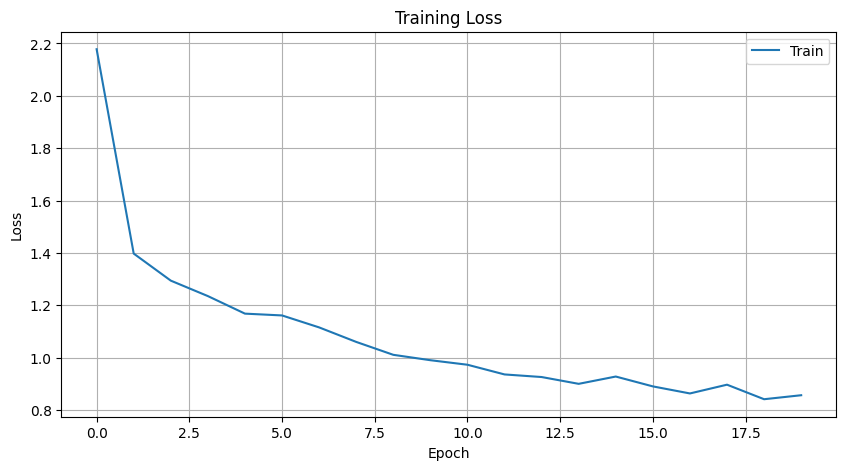

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(loss_log, label='Train')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# save model and loss pkl, npy
os.makedirs('output', exist_ok=True)
model.save('output/model_gp_20epoch_320reprdim_512batch_001lr_128dim_10depth.pkl')
np.save('output/loss_log_gp_20epoch_320reprdim_512batch_001lr_128dim_10depth.npy', np.array(loss_log))
# np.save('output/val_loss_log.npy', np.array(val_loss_log))
print("Saved")

Saved


In [24]:
# extract representations to visualize with tsne
train_repr = model.encode(train_data, encoding_window='full_series')
# val_repr = model.encode(val_data, encoding_window='full_series')
print(f"Train representations: {train_repr.shape}")
# print(f"Val representations: {val_repr.shape}")
np.save('output/train_representations.npy', train_repr)
# np.save('output/val_representations.npy', val_repr)

Extracting representations...
Train representations: (206565, 320)


In [25]:
# download files
files.download('output/model_gp_20epoch_320reprdim_512batch_001lr_128dim_10depth.pkl')
# files.download('output/train_representations.npy')
# files.download('output/val_representations.npy')
files.download('output/loss_log_gp_20epoch_320reprdim_512batch_001lr_128dim_10depth.npy')
# files.download('output/val_loss_log.npy')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

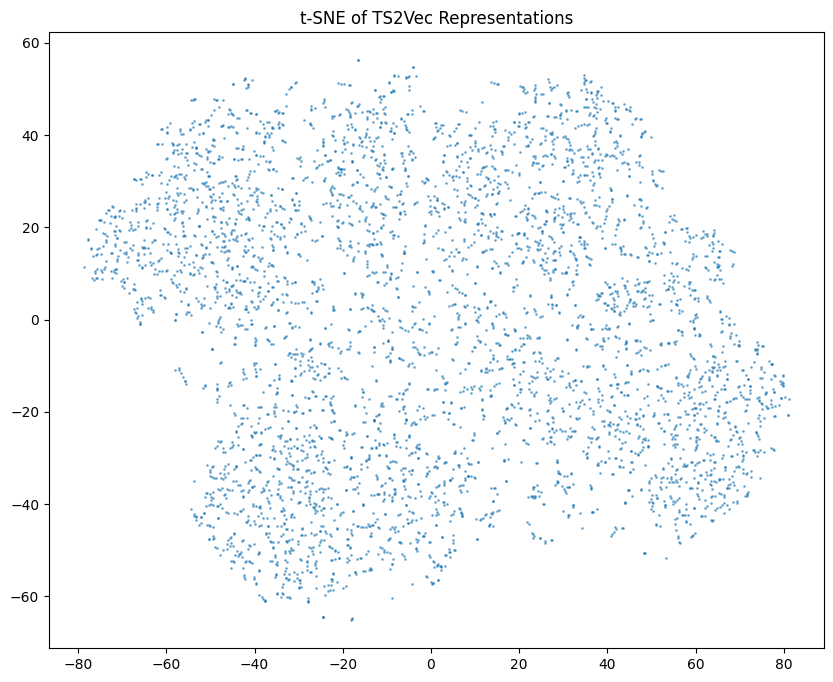

In [26]:
# good thing is since ts2vec outputs are embeddings, we can visualize and check whether or not we see clusters even without labels
from sklearn.manifold import TSNE

all_repr = train_repr

# its too much if we plot everything, so select 5000 repr
n_samples = min(5000, len(all_repr))
idx = np.random.choice(len(all_repr), n_samples, replace=False)
sample = all_repr[idx]

# changing n components didn't change visualization dramatically
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(sample)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=1, alpha=0.5)
plt.title('t-SNE of TS2Vec Representations')
plt.show()